# **TITANIC Verisi için Python'da Veri Görselleştirme**


---

Kaynak:[Pandas & Seaborn - A guide to handle & visualize data in Python](https://)


---


[<img align="right" width="100" height="100" src="http://www.i2symbol.com/images/symbols/style-letters/circled_latin_capital_letter_a_u24B6_icon_128x128.png">](https://www.ayyucekizrak.com/)

**Colab **için kimlik doğrulama işlemleri...

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [1]:
!mkdir -p drive
!google-drive-ocamlfuse drive

/bin/bash: google-drive-ocamlfuse: command not found


In [ ]:
import os
os.chdir("/content/drive/titanic")
!pwd

/content/drive/titanic


Neden **Pandas** kütüphanesi kullanıyoruz? Çünkü **NumPy** üzerinde inşa edilmiştir. Manipülasyon ve analiz için daha yüksek seviyeli yöntemler sağlamak için çok boyutlu dizileri ve hızlı operasyonları dahili olarak kullanır. **Seaborn**'u da ***Titatic*** verisini çekmek için kullanıyoruz.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import timeit
import matplotlib.pyplot as plt

# Veri kümseini yükle
titanic = sns.load_dataset('titanic')

### Veri setine bir gözatalım :)

In [ ]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB


### *Örnek bir sorgu yapalım* ve aynı cinsiyet grubuna ait 1. ve 3. sınıf ve yaşamıyor olan yolcuların bilet ücretlerini, yolculukta yalnız olup olmadıklarını, hangi şehirden olduklarını gözlemleyelim.

In [ ]:
titanic[
    (titanic.sex == 'female')
    & (titanic['class'].isin(['First', 'Third']))
    & (titanic.age > 30)
    & (titanic.survived == 0)
]

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
18,0,3,female,31.0,1,0,18.0000,S,Third,woman,False,NaN,Southampton,no,False
40,0,3,female,40.0,1,0,9.4750,S,Third,woman,False,NaN,Southampton,no,False
132,0,3,female,47.0,1,0,14.5000,S,Third,woman,False,NaN,Southampton,no,False
167,0,3,female,45.0,1,4,27.9000,S,Third,woman,False,NaN,Southampton,no,False
177,0,1,female,50.0,0,0,28.7125,C,First,woman,False,C,Cherbourg,no,True
254,0,3,female,41.0,0,2,20.2125,S,Third,woman,False,NaN,Southampton,no,False
276,0,3,female,45.0,0,0,7.7500,S,Third,woman,False,NaN,Southampton,no,True
362,0,3,female,45.0,0,1,14.4542,C,Third,woman,False,NaN,Cherbourg,no,False
396,0,3,female,31.0,0,0,7.8542,S,Third,woman,False,NaN,Southampton,no,True
503,0,3,female,37.0,0,0,9.5875,S,Third,woman,False,NaN,Southampton,no,True


Veriden bir grup çekelim: Hangi ülke ve şehirden geldikleri bilgisi olsun.

In [ ]:
# Datadan küçük bir parça çekelim, yaşadıkları şehir, şehirde yaşadıkları süre ve şehir yaşı bilgileri olsun
towns_dic = {
    'name': ['Southampton', 'Cherbourg', 'Queenstown', 'Montevideo'],
    'country': ['United Kingdom', 'France', 'United Kingdom', 'Uruguay'],
    'population': [236900, 37121, 12347, 1305000],
    'age': [np.random.randint(500, 1000) for _ in range(4)]
}
towns_df = pd.DataFrame(towns_dic)

In [ ]:
(titanic.merge(
  towns_df, 
  left_on='embark_town', right_on='name', 
  how='left',
  indicator=True,
  suffixes=('_passenger', '_city')
)).head()
# 'head' takes the last n elements of the DataFrame

,survived,pclass,sex,age_passenger,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,name,country,population,age_city,_merge
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,Southampton,United Kingdom,236900.0,974.0,both
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,Cherbourg,France,37121.0,863.0,both
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,Southampton,United Kingdom,236900.0,974.0,both
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,Southampton,United Kingdom,236900.0,974.0,both
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,Southampton,United Kingdom,236900.0,974.0,both


**distplot:** Verilerinizi keşfederken görmek istediğiniz ilk şey, değişkenlerinizin dağılımıdır. 
Örneğin, Titanic’in yolcularının yaş dağılımını görelim.

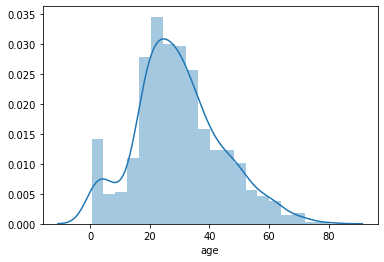

In [ ]:
sns.distplot(titanic.age.dropna())
plt.show()

**FacetGrid:** Bir grafiği (örneğin sonuncusu) bazı kategorilerden ayırmak isteyebiliriz!

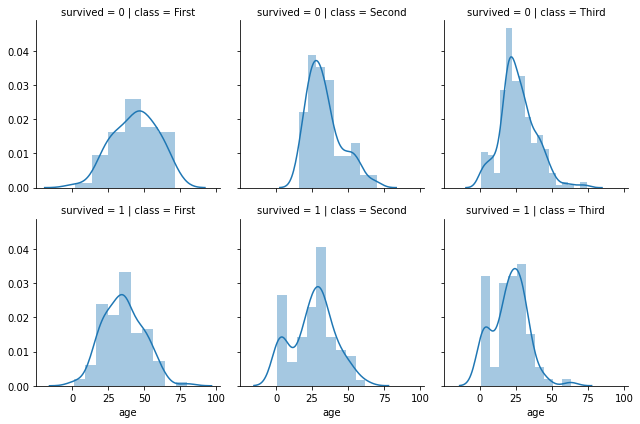

In [ ]:
g = sns.FacetGrid(titanic, row='survived', col='class')
g.map(sns.distplot, "age")
plt.show()

**jointplot:** Bu metot, veri değişkenlerinin hem dağılımları hem de çekirdek yoğunluğu tahmin edicileri ve verilere uyan bir opsiyonel regresyon ile birlikte iki değişkene göre görüntülenmesi için kullanılır. **Reg** ile, verilere uygun bir regresyon istediğimizi belirtiyoruz.
Bu durumda, regresyonun gösterdiği yukarı doğru küçük bir eğilim olduğu görünse de, ***Pearson korelasyon katsayısı*** ile gösterildiği gibi *“yaş”* ve *“ücret”* değişkenleri arasında hemen hemen hiçbir ilişki yoktur.

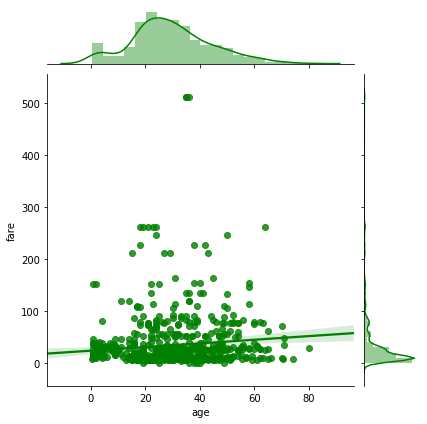

In [ ]:
sns.jointplot(data=titanic, x='age', y='fare', kind='reg', color='g')
plt.show()

Son olarak bir veri ile ilgili oluşturulabilecek en havalı şey korelasyon matrisidir :)
Sütunlarının tüm çiftleri arasındaki Pearson'ları (bir başka  yöntem de olabilir) korelasyon katsayısını hesaplayan bir düzeltme yöntemine sahiptir.